<a href="https://colab.research.google.com/github/RandomForestRanger/PhD/blob/master/Regressions_February_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installations
!pip install --upgrade -q gspread
!pip install gspread-dataframe
!pip install --upgrade Cython
!pip install --upgrade git+https://github.com/statsmodels/statsmodels
  
#! pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install # see if this works

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sklm
from sklearn import preprocessing as pp
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.svm import SVC,SVR 
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import NegativeBinomial    #
from statsmodels import discrete
from statsmodels.formula.api import ols

from scipy import stats
import scipy.stats as ss

from patsy import dmatrices

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

import warnings

%matplotlib inline

In [ ]:
### Step 1 ###
#authorise node to access Gdrive via KDL
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
### Step 2 ###
#import data (google drive csv)
#link to pre-opened csv file in my gdrive 
data1 = gc.open_by_url('link to google doc here')

#get the data as a worksheet  
ws = data1.worksheet('RegAll01')

#convert the data to pandas dataframe (can include argument , header = None   if this is needed)
Woernjaps = get_as_dataframe(ws, usecols=[1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,25,40]) #30,34,40,43,48,52,74,75

#since g-sheets brings along a lot of empty/Nan cellumns or rows, this chops them out. Can replace "all" with "any" if I want to discard any incomplete collumns or rows
Woernjaps.dropna(axis=1, how='all' ,inplace=True )
Woernjaps.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

Woernjaps.tail()

,Change in Population,% Unemployed,% Poor,Voter Turnout,Mean Age,Small Households,Percentage Youth,Dep Ratio,% White,% HWW,R-P Ratio,Gini,% PWM,% NSL,% Tribal,% Male,% Informal,% Rural,Urban=1,COGTA Score,AG Rating,Prov,NatLog7
229,32.0,36.0,19.0,72.46,27.495502,37.044553,32.417989,48.148148,5.961538,31.135380,5.205402,0.48,86.665856,0.790241,0.000000,51.579282,39.673050,39.673050,0.0,2.0,5.0,8.0,7.087675
230,34.0,34.0,19.0,83.02,28.323922,40.339771,37.217716,41.022583,16.033823,16.776172,14.510426,0.52,74.061356,2.840637,0.000000,51.445271,4.660040,4.660040,0.0,2.0,1.0,6.0,5.061979
231,-7.0,67.0,20.0,77.77,25.945665,25.146995,32.072400,53.870005,0.329700,83.246560,4.070981,0.39,84.535850,0.793188,90.271695,46.587342,0.000000,97.011744,0.0,4.0,2.0,4.0,4.228762
232,2.0,33.0,27.0,72.42,28.155124,55.381699,41.283517,32.573745,7.077280,35.074069,9.245362,0.52,74.483008,2.882927,0.000000,54.713335,26.959416,26.959416,0.0,1.0,2.0,3.0,9.013971
233,30.0,9.0,8.0,66.18,29.123616,35.633829,38.070843,37.204067,7.778822,9.157549,14.835113,0.47,81.262356,2.405668,0.000000,51.363589,4.954978,4.954978,0.0,1.0,2.0,9.0,5.625354


In [ ]:
Woernjaps.dtypes

In [ ]:
Woernjaps.describe()

In [ ]:
# if not scaling...
dataset = Woernjaps

In [ ]:
### Step 3 ###
#Scaling
dataset = Woernjaps
scaler = StandardScaler()

dataset[['Change in Population','% Unemployed','% Poor','Voter Turnout', 'Mean Age' ,'Small Households','Percentage Youth', 'Dep Ratio',
          '% White', '% HWW','R-P Ratio', 'Gini','% PWM',
          '% NSL','% Tribal','% Male','% Informal','% Rural']] = scaler.fit_transform(dataset[['Change in Population','% Unemployed','% Poor','Voter Turnout', 'Mean Age', 
                                                                                                                                          'Small Households','Percentage Youth', 'Dep Ratio','% White', '% HWW','R-P Ratio', 'Gini','% PWM',
                                                                                                                                          '% NSL','% Tribal','% Male','% Informal','% Rural']]) 
#dataset.tail() 

In [ ]:
### Step 4 ###
#Place data into new formats, including splitting off the target from the variables (DV from IVs)
observations = len(dataset)
variables = dataset.columns[:-1]

X = dataset.iloc[:, :-1] 
y = dataset['Target10'].values
#dataset.dtypes

#add constant term (for OLS)
Xc = sm.add_constant(X)

# Xc.describe().apply(lambda s: s.apply(lambda x: format(round(x,3), 'g'))) 
warnings.filterwarnings(action="ignore")

In [ ]:
### Step 5 ###
# OLS
Xc = pd.concat((Xc,pd.get_dummies(Xc['AG Rating'], prefix= "A", drop_first=True)), axis=1)
Xc.drop(['AG Rating'], axis=1, inplace=True)
Xc = pd.concat((Xc,pd.get_dummies(Xc['COGTA Score'], prefix= "C", drop_first=True)), axis=1)
Xc.drop(['COGTA Score'], axis=1, inplace=True)
#Xc = pd.concat((Xc,pd.get_dummies(Xc['Urban=1'], prefix= "U", drop_first=True)), axis=1)
Xc.drop(['Urban=1'], axis=1, inplace=True)
#Xc = pd.concat((Xc,pd.get_dummies(Xc['Prov'], prefix="Prov", drop_first=True)), axis=1)
Xc.drop(['Prov'], axis=1, inplace=True)

# dropping unneeded collumns
Xc.drop(columns=['Change in Population','% Unemployed','Mean Age','Percentage Youth','% NSL','% Tribal',], axis=1, inplace=True)
Xc.drop(columns=['A_4.0','A_2.0','A_3.0','A_5.0','% HWW', '% Poor','% White','% Male','% PWM', 'Small Households','Dep Ratio','R-P Ratio','Gini','Voter Turnout','% Rural',], axis=1, inplace=True)
## Feature bank
# 'C_2.0','C_3.0','C_4.0','% Informal',
# 
#  

linear_regression = sm.OLS(y,Xc)
fitted_model = linear_regression.fit()

#Look at model summary
fitted_model.summary()
#fitted_model.conf_int(alpha=0.05, cols=None)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.930
Date:                Fri, 21 Feb 2020   Prob (F-statistic):           1.02e-06
Time:                        12:35:42   Log-Likelihood:                 28.336
No. Observations:                 234   AIC:                            -46.67
Df Residuals:                     229   BIC:                            -29.39
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6186      0.032     19.381      0.000       0.556       0.682
% Informal     0.0078      0.003      2.609      0.010       0.002       0.014
C_2.0         -0.0914      0.040     -2.310      0.022      -0.169      -0.013
C_3.0         -0.0940      0.041     -2.297      0.023      -0.175      -0.013
C_4.0         -0.1735      0.042     -4.106      0.000      -0.257      -0.090
==============================================================================
Omnibus:                       11.101   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.213
Skew:                          -0.499   Prob(JB):                      0.00367
Kurtosis:                       2.607   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Plot of target
#Woernjaps['Inequality'] = np.log(Woernjaps['Inequality']+1)
plt.figure(figsize=(9,9))

sns.scatterplot(x= Woernjaps['Gini'], y=Woernjaps['NatLog7'], hue= Woernjaps['Prov'],palette="nipy_spectral", legend='full', )
#sns.distplot(Woernjaps['Target1'], color="dodgerblue", kde = False )  
#plt.title('Histogram of protests per municipality')
plt.xlabel('Standardised Gini')
plt.ylabel('General Propensity')

In [ ]:
plt.figure(figsize=(7,7))
sns.regplot(x= np.log(dataset['R-P Ratio']), y=Woernjaps['NatLog7'], truncate=False, color='maroon',  )
plt.xlabel('Standardised R-P Ratio')
plt.ylabel('General Propensity')

In [ ]:
# The Robust model
rlm_model = sm.RLM(y, Xc, M=sm.robust.norms.HuberT())
fitted_model = rlm_model.fit()

#Look at model summary
fitted_model.summary()

In [ ]:
#Weighted Least Squares
Xc.drop(columns=['Pop'], inplace = True)
wls_model = sm.WLS(y,Xc, weights=dataset['Pop'] )
fitted_model = wls_model.fit()

#Look at model summary
fitted_model.summary()

In [ ]:
# The Frequency-Weighted model
import statsmodels.formula.api as smf

f = """ Q('Target2') ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Q('Mean_Age')	+ Q('Small_Households') + Q('Percentage_Youth') + Q('Percentage_NWA') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL') + Q('Percentage_Tribal') + Q('Percentage_Male')	+ Q('Percentage_Informal') +  Q('Percentage_IOT') + C(AG_Rating) + C(COGTA_Score) """
glm = smf.glm(f, data=dataset, family=sm.families.q(),  freq_weights=np.asarray(dataset['Pop']))
res_f = glm.fit()
print(res_f.summary())
#family=sm.families.GLM()


In [ ]:
# VIF Calcs
Xc.drop(['const'], axis=1, inplace=True)

print("VIF Scores for each variable: ")
pd.Series([variance_inflation_factor(Xc.values, i) 
               for i in range(Xc.shape[1])], 
              index=Xc.columns)

VIF Scores for each variable: 


Change_in_pop              2.619883
WAP_not_working           10.778952
HH_Income_Percent_Poor     3.710200
Voter_Turnout              1.843959
Mean_Age                  11.200188
Small_Households           4.590423
Percentage_Youth          15.015833
Percentage_NWA            38.710204
Percentage_White           7.115037
Percentage_HHWW            9.255988
Inequality                 3.784393
Gini                       3.935181
Percentage_PWM            11.826967
Percentage_NSL             2.393031
Percentage_Tribal         49.226610
Percentage_Male            5.315134
Percentage_Informal        2.452701
Percentage_IOT            63.493223
A_2.0                      3.924223
A_3.0                      2.807667
A_4.0                      1.321999
A_5.0                      4.677388
C_2.0                      2.681480
C_3.0                      4.106566
C_4.0                      9.364878
dtype: float64

In [ ]:
# Feature extraction: RFE rankings
model = LinearRegression()
rfe = RFE(model, 1)
fit = rfe.fit(Xc, y)
#print("Num Features: %s" % (fit.n_features_))
#print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: \n %s" % (fit.ranking_))
#print(Xc.columns)

Feature Ranking: 
 [23 24  8 12 25  6 22  7 14 10 19  1  9 21 17 13 18 16  2  4  5  3 15 20
 11]


In [ ]:
# RFE with Cross Validation. This is fantastic.
# Create the RFE object and compute a cross-validated score.
ols = linear_model.LinearRegression()
rfecv = RFECV(estimator=ols, step=1, cv=KFold(4), scoring='neg_root_mean_squared_error')   #can also do scoring with 'r2', 'accuracy', 'neg_root_mean_squared_error', 'explained_variance' , etc.
rfecv.fit(Xc, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

feature_names = ['Change_in_pop','WAP_not_working','HH_Income_Percent_Poor','Voter_Turnout','Mean_Age','Small_Households','Percentage_Youth','Percentage_NWA','Percentage_White','Percentage_HHWW','Inequality','Gini','Percentage_PWM','Percentage_NSL','Percentage_Tribal','Percentage_Male','Percentage_Informal','Percentage_IOT','A_2.0','A_3.0','A_4.0','A_5.0','C_2.0','C_3.0','C_4.0']
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
  if(value[1]) == True:
    new_features.append(value[0])
        
print(new_features)

In [ ]:
#Eigenvalues 
corr = np.corrcoef(Xc, rowvar=0)
eigenvalues, eigenvectors = np.linalg.eig(corr)
#check for low eigenvalues (under 0.1)
np.set_printoptions(suppress=True) #to suppress scientific notation
print(np.round(eigenvalues, 2))

In [ ]:
# Another RFE CV way - using "yellowbrick"
# 1. Import
from yellowbrick.features import RFECV
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [ ]:
# 2. Specify model
model=LinearRegression()

Optimum no. of features to be selected using Recursive feature elimination
1


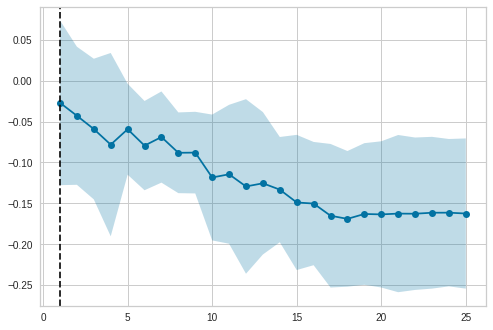

In [ ]:
# 3. Graph
print('Optimum no. of features to be selected using Recursive feature elimination')
viz = RFECV(model)
viz.fit(Xc, y)
k=int(viz.n_features_)
print(k)

In [ ]:
# 4. Name features
viz.poof()
efs1 = EFS(model, min_features=k, max_features=12, scoring='r2', cv=14)
efs1 = efs1.fit(Xc, y)
# This doesn't work yet...

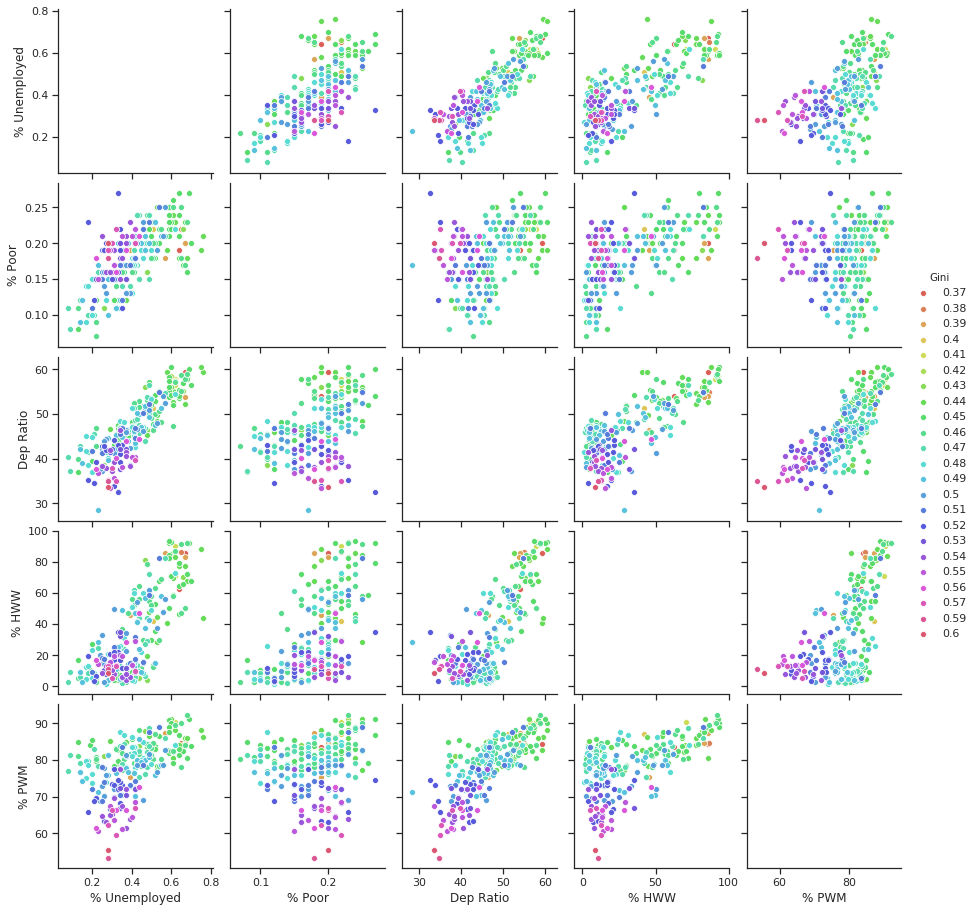

In [ ]:
# Pairplot
#Woernjaps.drop(['% Tribal', 'R-P Ratio','% Rural', 'Urban=1', 'COGTA Score','AG Rating', 'Prov', '2NatLog' ,'Mean Age', '% NSL', '% Male', '% Informal', 'Small Households', 'Change in Population', '% White', 'Percentage Youth','Voter Turnout'], axis=1, inplace=True)

sns.set(style="ticks")
sns.pairplot(Woernjaps, palette="hls", diag_kind="None", hue="Gini" ) #can add hue="HHsIneq*10" , which will make a very pretty visual, but will take 5 mins to generate 

#Add contant back
#Xc = sm.add_constant(X)

In [ ]:
# Neg Binomial (old way)

f = """ Target1 ~  Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Q('Mean_Age')	+ Q('Small_Households') + Q('Percentage_Youth') + Q('Percentage_NWA') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Gini') + Q('Percentage_PWM') + Q('Percentage_NSL') + Q('Percentage_Tribal') + Q('Percentage_Male')	+ Q('Percentage_Informal') +  Q('Percentage_IOT') + C(AG_Rating) + C(COGTA_Score)  """
#    
data =  dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

# Method 1 for Neg Binomial 
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

In [ ]:
# Doing NB regression using Statsmodels
linear_regression = NegativeBinomial(y, Xc, loglike_method='nb2', offset=None, exposure=None, missing='none')

fitted_model = linear_regression.fit()
fitted_model.summary()

In [ ]:
# Yet another way for NB (also OLD)
f = """ Target1 ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Mean_Age	+ Q('Small_Households') + Q('Percentage_NWA') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL') + Q('Percentage_Tribal') + Q('Percentage_Male')	+ Q('Percentage_Informal')  + C(AG_Rating)  """
data = dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

# Method 1 for Neg Binomial 
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

In [ ]:
# Drop superfluous features
Xc.drop(['Large_Households',  'Percentage_Youth', 'Percentage_IOT', 'COGTA_Score', 'Percentage_Poor'], axis=1, inplace=True)
print(Xc.columns[1:])

<Figure size 1512x1512 with 0 Axes>

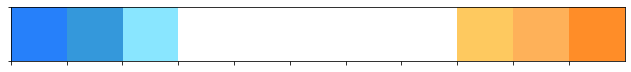

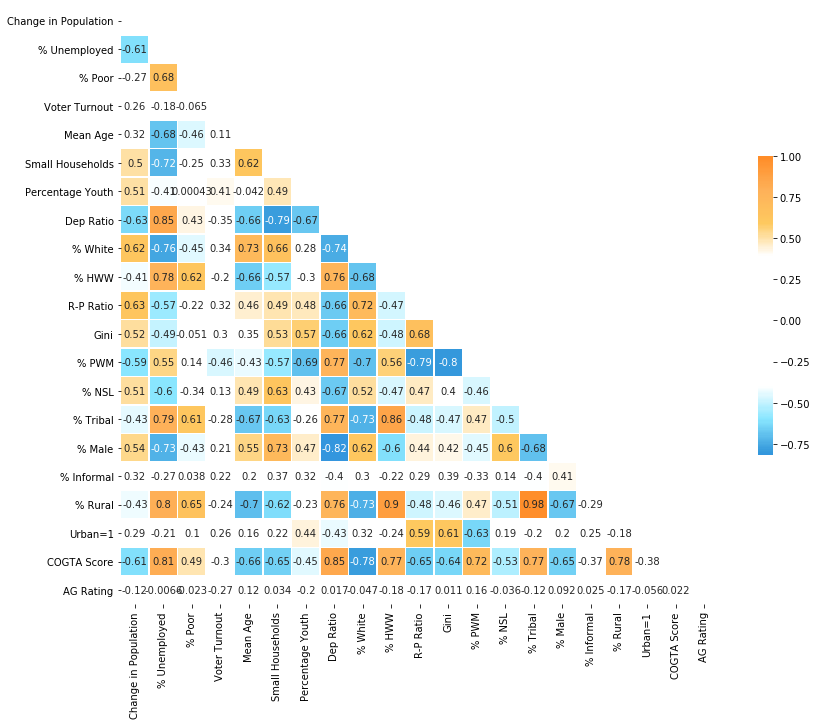

In [ ]:
#Correlation table 

#Temporarily drop constant
Xc.drop(['const', 'Prov'], axis=1, inplace=True)

plt.figure(figsize=(21,21))
hurdle = 0.0
R = np.corrcoef(Xc, rowvar=0) 
R[np.where(np.abs(R)<hurdle)] = 0.0

MJB = ["#2680FA", "#3498db", "#89E6FF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FEC95F", "#FEB159", "#FF8D28"]
sns.set_palette(MJB)
sns.palplot(sns.color_palette())

cmap = LinearSegmentedColormap.from_list('mycmap', MJB)

# Generate a mask for the upper triangle
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 11))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True, )
#cmap="Spectral"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, annot=True, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=Xc.columns[:], yticklabels=Xc.columns[:] )

#Add contant back
Xc = sm.add_constant(X)

In [ ]:
Xc.drop(['Percentage_Tribal',  'Percentage_NWA' ], axis=1, inplace=True)

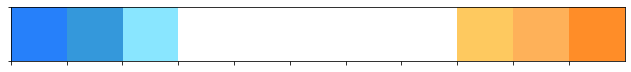

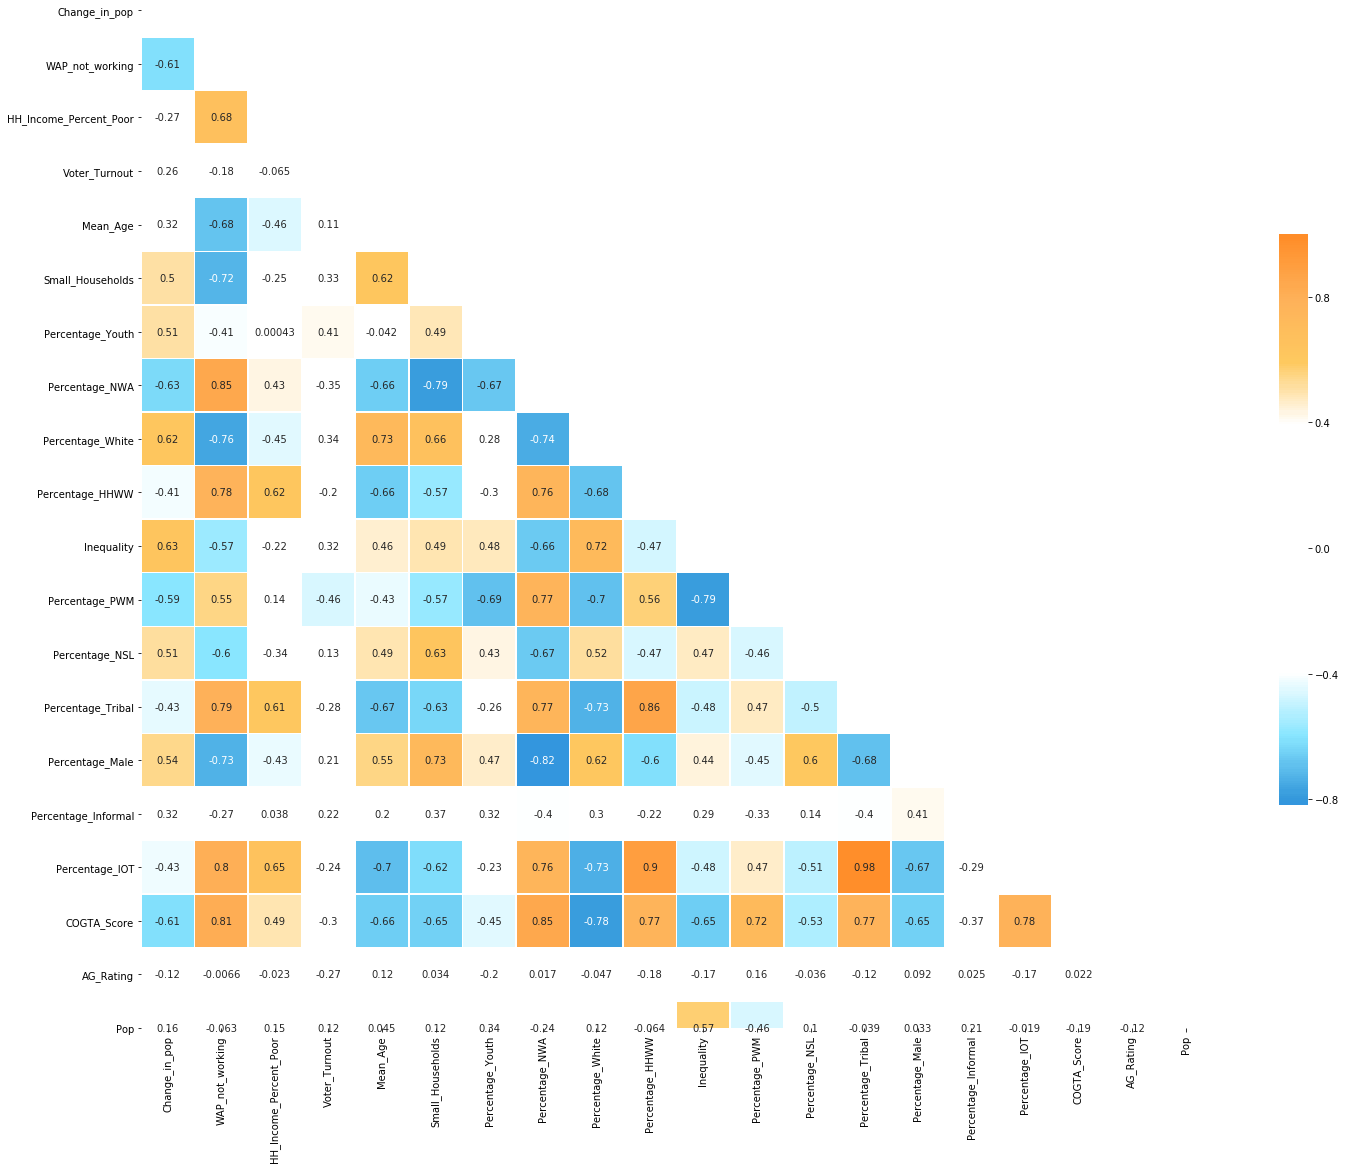

In [ ]:
#Correlation table 

#Temporarily drop constant
#Xc.drop('const', axis=1, inplace=True)

hurdle = 0.0
R = np.corrcoef(X, rowvar=0) 
R[np.where(np.abs(R)<hurdle)] = 0.0

MJB = ["#2680FA", "#3498db", "#89E6FF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FFFFFF", "#FEC95F", "#FEB159", "#FF8D28"]
sns.set_palette(MJB)
sns.palplot(sns.color_palette())

cmap = LinearSegmentedColormap.from_list('mycmap', MJB)

# Generate a mask for the upper triangle
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24, 21))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, annot=True, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=Xc.columns[:], yticklabels=Xc.columns[:] )

#Add contant back
#Xc = sm.add_constant(X)

In [ ]:
f = """ Target1 ~ Q('Change_in_pop') + Q('WAP_not_working') + Q('HH_Income_Percent_Poor') + Q('Voter_Turnout') + Mean_Age	+ Q('Small_Households') + Q('Percentage_White')+ Q('Percentage_HHWW')	+ Q('Inequality')	+ Q('Percentage_PWM') + Q('Percentage_NSL')  + Q('Percentage_Male')	+ Q('Percentage_Informal')  + C(AG_Rating)  """
data = dataset

response, predictors = dmatrices(f, data, return_type='dataframe')

# Method 1 for Neg Binomial 
nb_results = sm.GLM(response, predictors, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

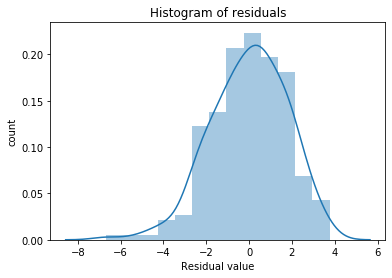

In [ ]:
# Residual plots
from sklearn import linear_model
lm = LinearRegression()
lm.fit(Xc,y)
y_score = lm.predict(Xc)

def hist_resids(y, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y, y_score)

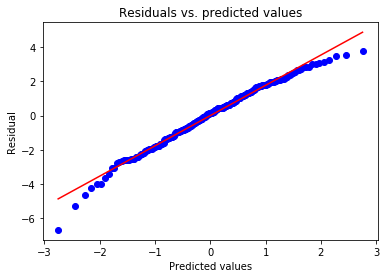

In [ ]:
def resid_qq(y, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y, y_score)

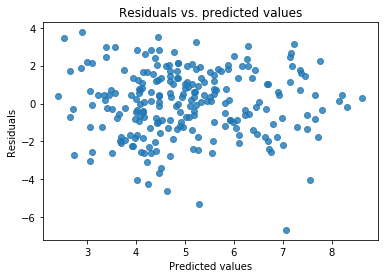

In [ ]:
def resid_plot(y, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False )
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')

resid_plot(y, y_score)

In [ ]:
#Towards the two heterokedastic tests
#Step1
# copied for article at  https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
#Step2
f = """Q('2NatLog') ~ Q('Change_in_pop')+Q('WAP_not_working')+Q('Percentage_White')+Q('Voter_Turnout')+Q('Percentage_Youth')+ Q('Inequality')+Q('Percentage_PWM')+Q('Percentage_NSL')+Q('Percentage_Informal')+C(COGTA_Score)+C(AG_Rating)"""

model = ols(formula=f, data=dataset).fit()

In [ ]:
#Step3
white_test = het_white(model.resid,  model.model.exog)

In [ ]:
#Step4
bp_test = het_breuschpagan(model.resid, dataset[['Change_in_pop','WAP_not_working','Voter_Turnout','Percentage_Youth','Percentage_White','Percentage_PWM','Percentage_NSL','Percentage_Informal'] ])

In [ ]:
#Step5
labels = ["LM_Statistic", "LM-Test_p-value", "F-Statistic", "F-Test_p-value"]
print(dict(zip(labels, bp_test)))
print(dict(zip(labels, white_test)))

{'LM_Statistic': 12.087567182517427, 'LM-Test_p-value': 0.09771569975393998, 'F-Statistic': 1.538777113885147, 'F-Test_p-value': 0.14487307562499113}
{'LM_Statistic': 83.89584195489125, 'LM-Test_p-value': 0.9966247717977315, 'F-Statistic': 0.5085233064582946, 'F-Test_p-value': 0.9998558969245661}
